In [107]:
from skvideo.io import vread
import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, Dense, GlobalAveragePooling1D, Flatten
from keras.utils import to_categorical
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

def compute_mean_flow(video):
    gvideo = [cv2.resize(cv2.cvtColor(x, cv2.COLOR_RGB2GRAY), (80, 45)) for x in video]
    T = len(gvideo)
    mean_flow = np.zeros((T, 2))
    for t in range(T):
        im1 = gvideo[np.max((0, t - 1))]
        im2 = gvideo[t]
        flow = cv2.calcOpticalFlowFarneback(im1, im2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mean_flow[t] = flow.mean(axis=(0, 1))
    return mean_flow

In [167]:
v1 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/positive/*_f.mp4')]
v2 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/negative/*_f.mp4')]
v3 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/attention/*_f.mp4')]
v4 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/pointing/*_f.mp4')]
v5 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/passing/*_f.mp4')]
v6 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/receiving/*_f.mp4')]
v7 = [compute_mean_flow(vread(x)) for x in glob('yks_cvpr2016_sub/gesture/*_f.mp4')]
X = v1 + v2 + v3 + v4 + v5 + v6 + v7
X = np.stack(X)
Y = to_categorical(np.hstack((np.ones(len(v1))* 0, np.ones(len(v2))* 1, np.ones(len(v3))* 2, 
                              np.ones(len(v4))* 3, np.ones(len(v5))* 4, np.ones(len(v6))* 5, np.ones(len(v7))* 6
                             )))

KeyboardInterrupt: 

In [175]:
x = Input(shape=(90, 2))
h = Conv1D(32, 5, activation='relu')(x)
h = Conv1D(32, 5, strides=2, activation='relu')(x)
h = Conv1D(64, 5, activation='relu')(h)
h = Conv1D(64, 5, strides=2, activation='relu')(h)
h = Conv1D(128, 5, activation='relu')(h)
h = Conv1D(128, 5, strides=2, activation='relu')(h)
h = GlobalAveragePooling1D()(h)
h = Dense(128, activation='relu')(h)
h = Dense(7, activation='softmax')(h)
model = Model(x, h)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [174]:
idx = np.random.permutation(len(Y))
train_idx = idx[:750]
test_idx = idx[750:]
Xtrain = X[train_idx]
Xtest = X[test_idx]
Ytrain = Y[train_idx]
Ytest = Y[test_idx]

In [176]:
model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=20)

Train on 750 samples, validate on 161 samples
Epoch 1/20
750/750 [==============================] - 3s 4ms/step - loss: 1.8479 - acc: 0.2040 - val_loss: 1.5847 - val_acc: 0.4099
Epoch 2/20
750/750 [==============================] - 0s 538us/step - loss: 1.5724 - acc: 0.3493 - val_loss: 1.4160 - val_acc: 0.4224
Epoch 3/20
750/750 [==============================] - 0s 609us/step - loss: 1.4575 - acc: 0.4227 - val_loss: 1.3207 - val_acc: 0.4658
Epoch 4/20
750/750 [==============================] - 0s 551us/step - loss: 1.3622 - acc: 0.4573 - val_loss: 1.2482 - val_acc: 0.5217
Epoch 5/20
750/750 [==============================] - 0s 588us/step - loss: 1.3109 - acc: 0.4867 - val_loss: 1.2771 - val_acc: 0.5155
Epoch 6/20
750/750 [==============================] - 0s 545us/step - loss: 1.3049 - acc: 0.4867 - val_loss: 1.2338 - val_acc: 0.5652
Epoch 7/20
750/750 [==============================] - 0s 644us/step - loss: 1.2898 - acc: 0.4973 - val_loss: 1.2401 - val_acc: 0.5031
Epoch 8/20
750/750

In [177]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(np.argmax(Ytest, axis=1), np.argmax(model.predict(Xtest), axis=1))

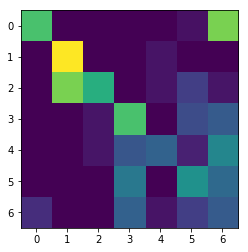

In [178]:
plt.imshow(cmat * 1. / cmat.sum(axis=1))